<a href="https://colab.research.google.com/github/catalinakarinip/mercadolabroal/blob/main/mercadolaboral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script 1: Limpieza bases INE

Para actualizar las bases limpias se debe
1. Subir las bbdd originales del INE
2. Ver si la base de diccionario "variables_por_base" mantiene las columnas, y por tanto las abreviaturas corresponden
3. Cambiar nombre del archivo al compatible con la base de diccionario

El code se demora 1 min en crear todas las bases limpias!!


In [ ]:
# ================= 0. MONTAR DRIVE =====================================
from google.colab import drive
drive.mount('/content/drive')

In [10]:
# ================= 1. LIBRERÍAS Y RUTA ========================================
from pathlib import Path
import pandas as pd
import re

ROOT = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio")
ORIG_DIR = ROOT / "Datos_ENE_originales"
CLEAN_DIR = ROOT / "Datos_ENE_limpios"
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

MAP_FILE = ROOT / "resultados/variables_por_base.xlsx"
MAP_SHEET = 0

# ================= 2. DICCIONARIO DE ABREVIATURAS =====================
def load_abbreviations() -> dict:
    df_map = (
        pd.read_excel(MAP_FILE, sheet_name=MAP_SHEET, usecols="A:C")
        .rename(columns=str.lower)
        .dropna()
    )
    df_map["base"] = (
        df_map["base"].str.strip().str.replace(".xlsx", "", regex=False).str.lower()
    )
    df_map["var_original"] = df_map["var_original"].str.strip()
    df_map["abreviatura"] = df_map["abreviatura"].str.strip()
    return {(r.base, r.var_original): r.abreviatura for r in df_map.itertuples()}

# ================= 4. HOJAS A CONSERVAR ================================
ID_VARS = ["Año", "Trimestre"]
HOJAS_OBJETIVO = {
    "AS",
    "AP",
    "TA",
    "AN",
    "AT",
    "CO",
    "VA",
    "RM",
    "LI",
    "ML",
    "NB",
    "BI",
    "AR",
    "LR",
    "LL",
    "AI",
    "MA",
}

# ================= 5. CONVERSIÓN NÚMEROS LATINOS =======================

LATIN_NUMBER_RE = re.compile(r"^\d{1,3}(\.\d{3})*(,\d+)?$")

def texto_a_numero(valor: str):
    if pd.isna(valor):
        return None
    texto = str(valor)
    if LATIN_NUMBER_RE.match(texto):
        texto = texto.replace(".", "").replace(",", ".")
    else:
        texto = texto.replace(",", ".")
    try:
        return float(texto)
    except ValueError:
        return None

# ================= 6. LIMPIADOR DE HOJAS ===============================
def limpiar_hoja(df: pd.DataFrame, base_alias: str, abbr: dict) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.strip()
    columnas_a_borrar = []
    renombres = {}
    columnas = list(df.columns)

    for i, col in enumerate(columnas):
        if col in ID_VARS or "Unnamed" not in col:
            continue
        anterior = columnas[i - 1].strip() if i > 0 else ""
        if anterior in ID_VARS or not anterior:
            columnas_a_borrar.append(col)
            continue
        alias = abbr.get((base_alias, anterior))
        if alias:
            renombres[col] = f"{alias}_{base_alias}"
        else:
            columnas_a_borrar.append(col)

    df = df.drop(columns=columnas_a_borrar, errors="ignore").rename(columns=renombres)
    df = df[df[ID_VARS[0]].notna() | df[ID_VARS[1]].notna()].reset_index(drop=True)

    for col in renombres.values():
        df[col] = df[col].apply(texto_a_numero)

    return df[[*ID_VARS, *renombres.values()]]

# ================= 7. PROCESAR ARCHIVOS =================================
def procesar_archivos():
    abbr = load_abbreviations()
    for src in ORIG_DIR.glob("*.xlsx"):
        base_alias = src.stem.split("_")[0].lower()
        dest = CLEAN_DIR / f"{base_alias}_limpia.xlsx"
        if dest.exists() and dest.stat().st_mtime >= src.stat().st_mtime:
            print(f"↻  Ya limpio: {dest.name}")
            continue
        print(f"→ Procesando {src.name} (base={base_alias})")
        xls = pd.ExcelFile(src)
        with pd.ExcelWriter(dest, engine="openpyxl") as xlw:
            hojas_guardadas = 0
            for hoja in xls.sheet_names:
                if hoja not in HOJAS_OBJETIVO:
                    continue
                try:
                    raw = xls.parse(hoja, header=5, dtype=str)
                    limpio = limpiar_hoja(raw, base_alias, abbr)
                    if not limpio.empty:
                        limpio.to_excel(xlw, sheet_name=hoja, index=False)
                        hojas_guardadas += 1
                except Exception as e:
                    print(f"⚠️ Error en hoja '{hoja}': {e}")
            if hojas_guardadas == 0:
                print(f"⚠️ Ninguna hoja válida guardada en {src.name}")
    print("\n✅ Limpieza completada. Archivos en:", CLEAN_DIR)

if __name__ == "__main__":
    procesar_archivos()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
→ Procesando rama.xlsx (base=rama)
→ Procesando informalidadtasas.xlsx (base=informalidadtasas)
→ Procesando informalidadrama.xlsx (base=informalidadrama)
→ Procesando informalidadgrupo.xlsx (base=informalidadgrupo)
→ Procesando informalidadcategoria.xlsx (base=informalidadcategoria)
→ Procesando indicadoresprincipales.xlsx (base=indicadoresprincipales)
→ Procesando grupo.xlsx (base=grupo)
→ Procesando complementarios.xlsx (base=complementarios)
→ Procesando categoria.xlsx (base=categoria)

✅ Limpieza completada. Archivos en: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/Datos_ENE_limpios


# Script 2: Panel de datos

In [ ]:
# ================= 0. MONTAR DRIVE =====================================
from google.colab import drive
drive.mount('/content/drive')

In [11]:
# ================= 1. LIBRERÍAS Y PATH ========================================
from pathlib import Path
import pandas as pd
ROOT = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio")
CLEAN_DIR = ROOT / "Datos_ENE_limpios"

PANEL_FILE = ROOT / "resultados" / "panel_ENE_unificado.xlsx"

TRIM_OK = {"Ene - Mar", "Abr - Jun", "Jul - Sep", "Oct - Dic"}
MAPA = {
    "AP": "Arica y Parinacota",
    "TA": "Tarapacá",
    "AN": "Antofagasta",
    "AT": "Atacama",
    "CO": "Coquimbo",
    "VA": "Valparaíso",
    "RM": "Región Metropolitana",
    "LI": "O’Higgins",
    "ML": "Maule",
    "NB": "Ñuble",
    "BI": "Biobío",
    "AR": "Araucanía",
    "LR": "Los Ríos",
    "LL": "Los Lagos",
    "AI": "Aysén",
    "MA": "Magallanes",
    "AS": "Nacional",
}
REGIONES = set(MAPA.keys())
ID_VARS = ["Año", "Trimestre", "region_code", "region_name"]

# ================= 2.MAPEO INICIAL ===========================

def cargar_base(path: Path) -> pd.DataFrame:
    xls = pd.ExcelFile(path)
    registros = []
    for hoja in xls.sheet_names:
        if hoja not in REGIONES:
            continue
        df = pd.read_excel(xls, sheet_name=hoja)
        df = df[df["Trimestre"].isin(TRIM_OK)].copy()
        df["region_code"] = hoja
        df["region_name"] = MAPA[hoja]
        registros.append(df)
    if registros:
        return pd.concat(registros, ignore_index=True)
    return pd.DataFrame(columns=ID_VARS)


# ================= 3. CONSTRUCCIÓN DEL PANEL ===========================
def construir_panel():
    panel = None
    for archivo in CLEAN_DIR.glob("*_limpia.xlsx"):
        df_base = cargar_base(archivo)
        if df_base.empty:
            continue
        if panel is None:
            panel = df_base
        else:
            panel = pd.merge(panel, df_base, on=ID_VARS, how="outer")
    if panel is None:
        print("No se encontraron archivos limpios")
        return
    panel = panel.sort_values(ID_VARS).reset_index(drop=True)
    TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
    panel["Periodo"] = pd.PeriodIndex(
        year=panel["Año"],
        quarter=panel["Trimestre"].map(TRIM_MAP),
        freq="Q"
    )
    panel["Fecha"] = panel["Periodo"].dt.start_time

    PANEL_FILE.parent.mkdir(parents=True, exist_ok=True)
    if PANEL_FILE.exists():
        print(f"↻  Reemplazando {PANEL_FILE.name}")
    panel.to_excel(PANEL_FILE, index=False)
    print("✅ Panel construido y guardado en:", PANEL_FILE)

if __name__ == "__main__":
    construir_panel()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Panel construido y guardado en: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx


# Script 3: BBDD anual 2024

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pandas as pd

# 1️⃣  Parámetros
archivo_excel = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
hoja_origen   = "data_panel"
anio          = 2024
hoja_filtrada = f"data_{anio}"
hoja_prom     = f"promedios_{anio}"

# 2️⃣  Leer la hoja principal y filtrar solo el año objetivo
df_anio = (
    pd.read_excel(archivo_excel, sheet_name=hoja_origen)
      .query("Año == @anio")
)

# 3️⃣  Calcular promedios regionales
indicadores = [
    "T_TDO_indicadoresprincipales",
    "T_TO_indicadoresprincipales",
    "T_TP_indicadoresprincipales",
    "T_TOI_A_informalidadtasas",
    "T_TOI_H_informalidadtasas",
    "T_TOI_M_informalidadtasas",
]

promedios = (
    df_anio.groupby("region_name")[indicadores]
           .mean()
           .reset_index()
           .round(3)
)

# 4️⃣  Escribir ambas hojas dentro del mismo archivo
with pd.ExcelWriter(
        archivo_excel,
        engine="openpyxl",
        mode="a",                 # append, mantiene las demás hojas intactas
        if_sheet_exists="replace" # reemplaza data_2024 / promedios_2024 si ya existen
    ) as writer:
    df_anio.to_excel(writer, sheet_name=hoja_filtrada, index=False)
    promedios.to_excel(writer, sheet_name=hoja_prom, index=False)

print(f"✅ Hoja «{hoja_filtrada}» ({len(df_anio)} filas) y «{hoja_prom}» ({len(promedios)} regiones) creadas/actualizadas.")

✅ Hoja «data_2024» (68 filas) y «promedios_2024» (17 regiones) creadas/actualizadas.


# Script 4: BBDD anual 2025

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import pandas as pd

# 1️⃣  Parámetros
archivo_excel = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
hoja_origen   = "data_panel"
anio          = 2025
hoja_filtrada = f"data_{anio}"
hoja_prom     = f"promedios_{anio}"

# 2️⃣  Leer la hoja principal y filtrar solo el año objetivo
df_anio = (
    pd.read_excel(archivo_excel, sheet_name=hoja_origen)
      .query("Año == @anio")
)
TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
df_anio["Periodo"] = pd.PeriodIndex(
    year=df_anio["Año"],
    quarter=df_anio["Trimestre"].map(TRIM_MAP),
    freq="Q"
)
df_anio["Fecha"] = df_anio["Periodo"].dt.start_time


# 3️⃣  Calcular promedios regionales
indicadores = [
    "T_TDO_indicadoresprincipales",
    "T_TO_indicadoresprincipales",
    "T_TP_indicadoresprincipales",
    "T_TOI_A_informalidadtasas",
    "T_TOI_H_informalidadtasas",
    "T_TOI_M_informalidadtasas",
]

promedios = (
    df_anio.groupby("region_name")[indicadores]
           .mean()
           .reset_index()
           .round(3)
)

# 4️⃣  Escribir ambas hojas dentro del mismo archivo
with pd.ExcelWriter(
        archivo_excel,
        engine="openpyxl",
        mode="a",                 # append, mantiene las demás hojas intactas
        if_sheet_exists="replace" # reemplaza data_2024 / promedios_2024 si ya existen
    ) as writer:
    df_anio.to_excel(writer, sheet_name=hoja_filtrada, index=False)
    promedios.to_excel(writer, sheet_name=hoja_prom, index=False)

print(f"✅ Hoja «{hoja_filtrada}» ({len(df_anio)} filas) y «{hoja_prom}» ({len(promedios)} regiones) creadas/actualizadas.")

✅ Hoja «data_2025» (17 filas) y «promedios_2025» (17 regiones) creadas/actualizadas.


# Script 3: Mapa calor

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


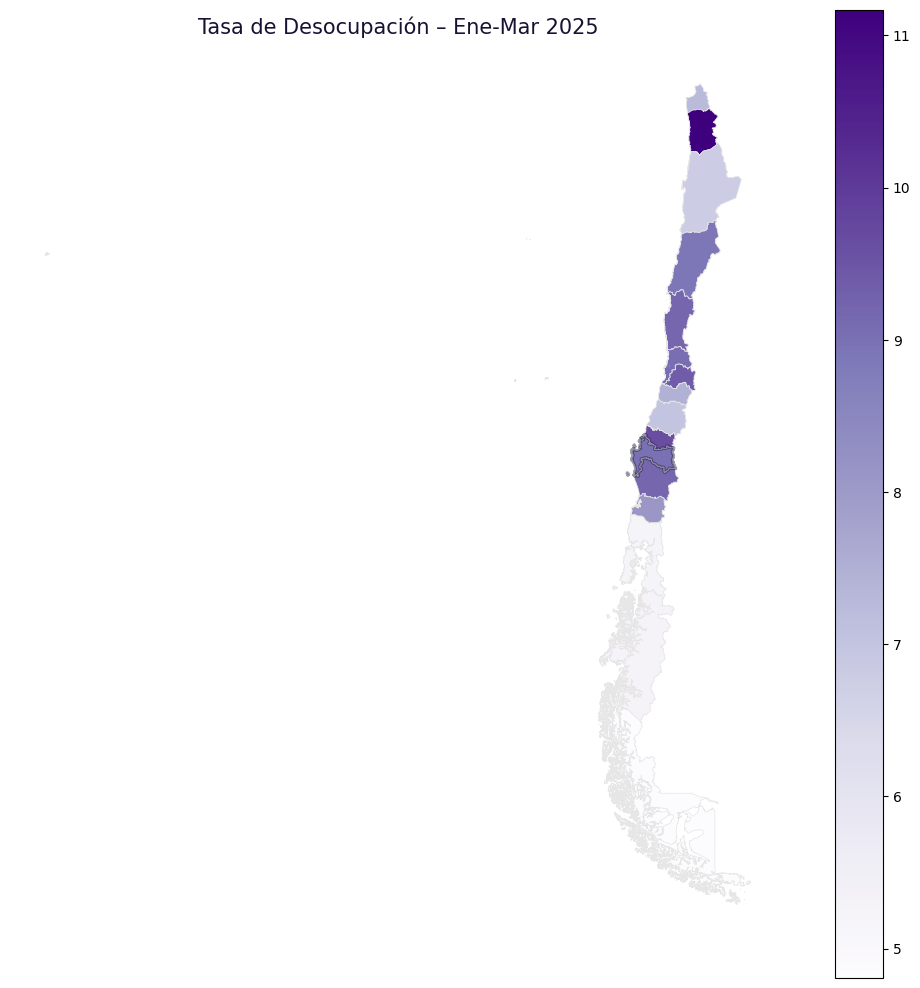

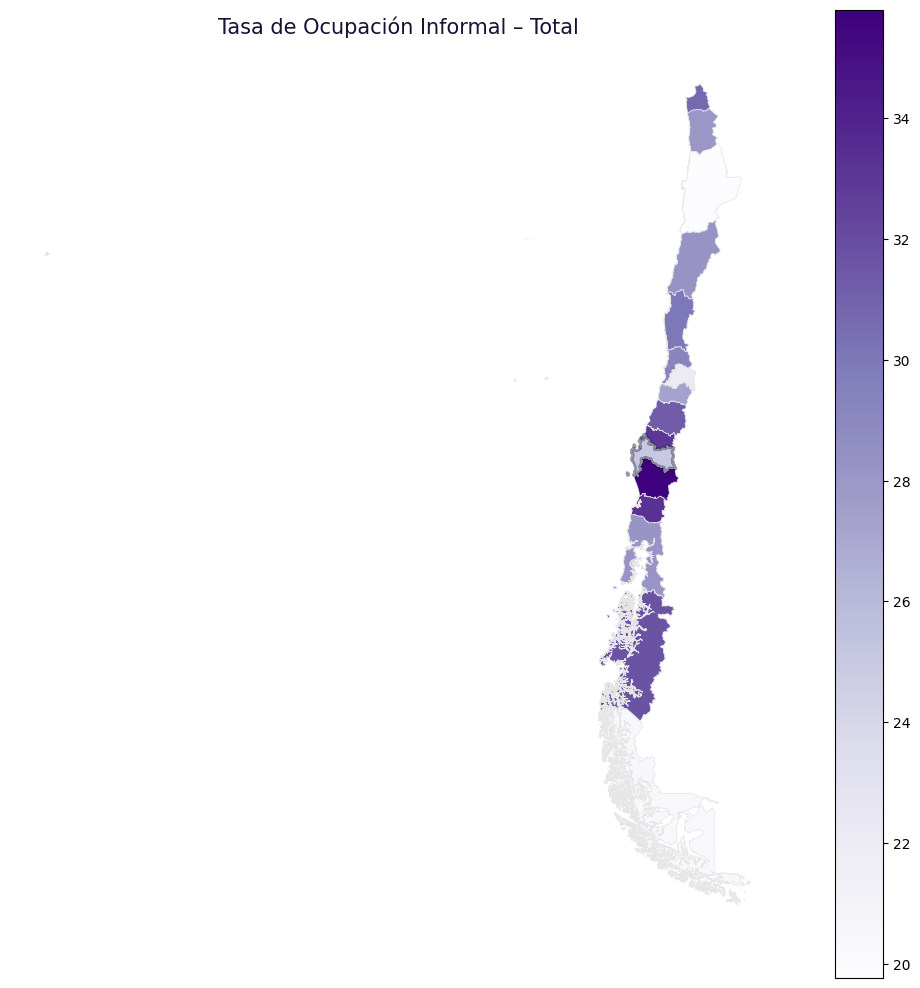

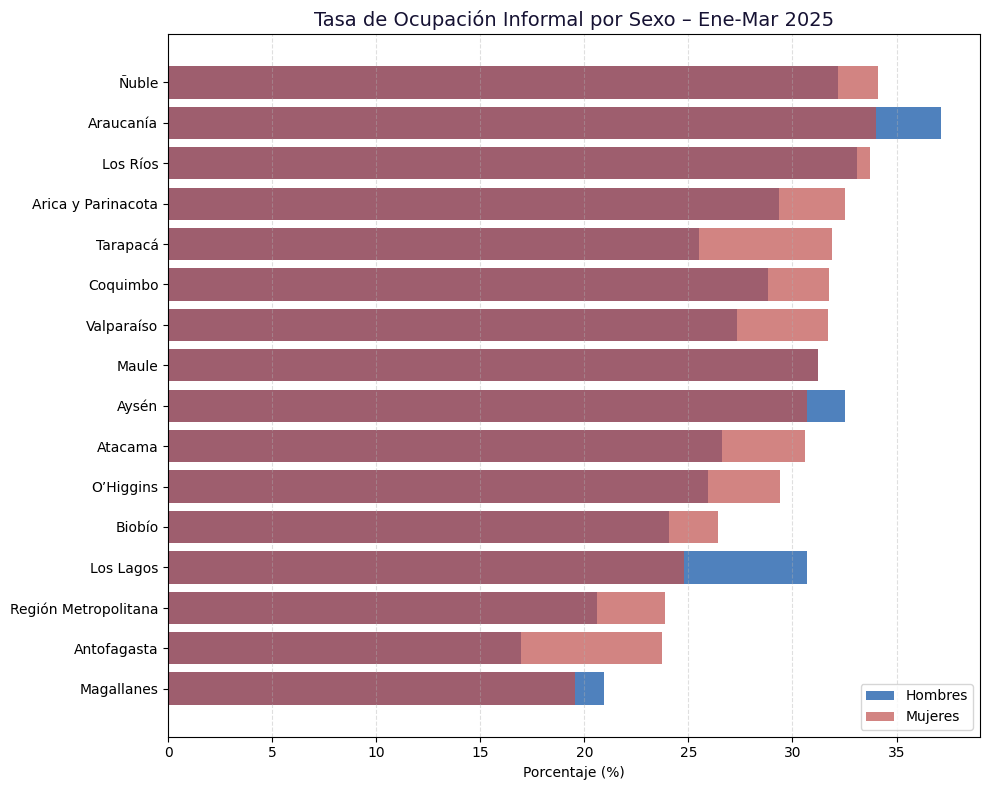

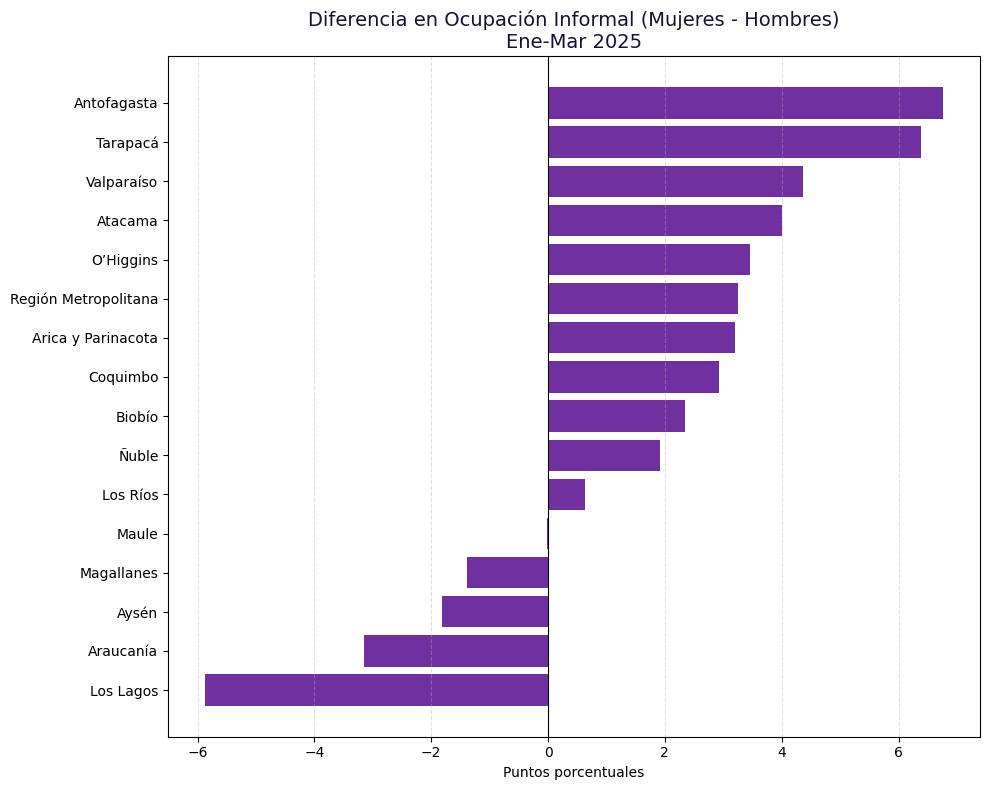

In [4]:
# 1. Librerías
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 2. Cargar datos
from google.colab import drive
drive.mount('/content/drive')

# 3. Paths
excel_path = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
shp_path = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/shp_regiones/Regional.shp"

# 4. Leer Excel
df = pd.read_excel(excel_path, sheet_name="TDO_2025")
df = df[df["region_name"] != "Nacional"]
TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
df["Periodo"] = pd.PeriodIndex(
    year=df["Año"],
    quarter=df["Trimestre"].map(TRIM_MAP),
    freq="Q"
)
df["Fecha"] = df["Periodo"].dt.start_time


# 5. Mapear nombres de región (para hacer merge con shapefile)
region_map = {
    'Antofagasta': 'Región de Antofagasta',
    'Araucanía': 'Región de La Araucanía',
    'Arica y Parinacota': 'Región de Arica y Parinacota',
    'Atacama': 'Región de Atacama',
    'Aysén': 'Región de Aysén del Gral.Ibañez del Campo',
    'Biobío': 'Región del Bío-Bío',
    'Coquimbo': 'Región de Coquimbo',
    'Los Lagos': 'Región de Los Lagos',
    'Los Ríos': 'Región de Los Ríos',
    'Magallanes': 'Región de Magallanes y Antártica Chilena',
    'Maule': 'Región del Maule',
    'O’Higgins': "Región del Libertador Bernardo O'Higgins",
    'Región Metropolitana': 'Región Metropolitana de Santiago',
    'Tarapacá': 'Región de Tarapacá',
    'Valparaíso': 'Región de Valparaíso',
    'Ñuble': 'Región de Ñuble'
}
df["Region_shp"] = df["region_name"].map(region_map)

# 6. Leer shapefile y hacer merge
gdf = gpd.read_file(shp_path)
gdf_merged = gdf.merge(df, left_on="Region", right_on="Region_shp")

# 7. Función para mapas
def plot_heatmap(gdf, column, title):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.plot(column=column, cmap="Purples", linewidth=0.5, edgecolor='0.9', ax=ax, legend=True)
    ax.set_facecolor("#ffffff")
    ax.set_title(title, fontsize=15, color="#161233")
    ax.axis("off")

    # Resaltar Biobío suavemente
    biobio = gdf[gdf["region_name"] == "Biobío"]
    biobio.plot(ax=ax, facecolor="none", edgecolor="#161233", linewidth=2, alpha=0.4)

    plt.tight_layout()
    plt.show()

# 8. Mapa: Tasa de Desocupación
plot_heatmap(
    gdf_merged,
    "T_TDO_indicadoresprincipales",
    "Tasa de Desocupación – Ene-Mar 2025"
)

# 9. Mapa: Tasa de Ocupación Informal (Total)
plot_heatmap(
    gdf_merged,
    "T_TOI_A_informalidadtasas",
    "Tasa de Ocupación Informal – Total"
)

# 10. Gráfico comparativo: Mujeres vs Hombres
df_bar = df.copy()
df_bar = df_bar.sort_values("T_TOI_M_informalidadtasas", ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(df_bar["region_name"], df_bar["T_TOI_H_informalidadtasas"], label="Hombres", color="#4F81BD")
plt.barh(df_bar["region_name"], df_bar["T_TOI_M_informalidadtasas"], label="Mujeres", color="#C0504D", alpha=0.7)
plt.title("Tasa de Ocupación Informal por Sexo – Ene-Mar 2025", fontsize=14, color="#161233")
plt.xlabel("Porcentaje (%)")
plt.legend(loc="lower right")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 11. Gráfico de diferencia (Mujeres - Hombres)
df_bar["diferencia_M_H"] = df_bar["T_TOI_M_informalidadtasas"] - df_bar["T_TOI_H_informalidadtasas"]
df_diff = df_bar.sort_values("diferencia_M_H", ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(df_diff["region_name"], df_diff["diferencia_M_H"], color="#7030A0")
plt.axvline(0, color='black', linewidth=0.8)
plt.title("Diferencia en Ocupación Informal (Mujeres - Hombres)\nEne-Mar 2025", fontsize=14, color="#161233")
plt.xlabel("Puntos porcentuales")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


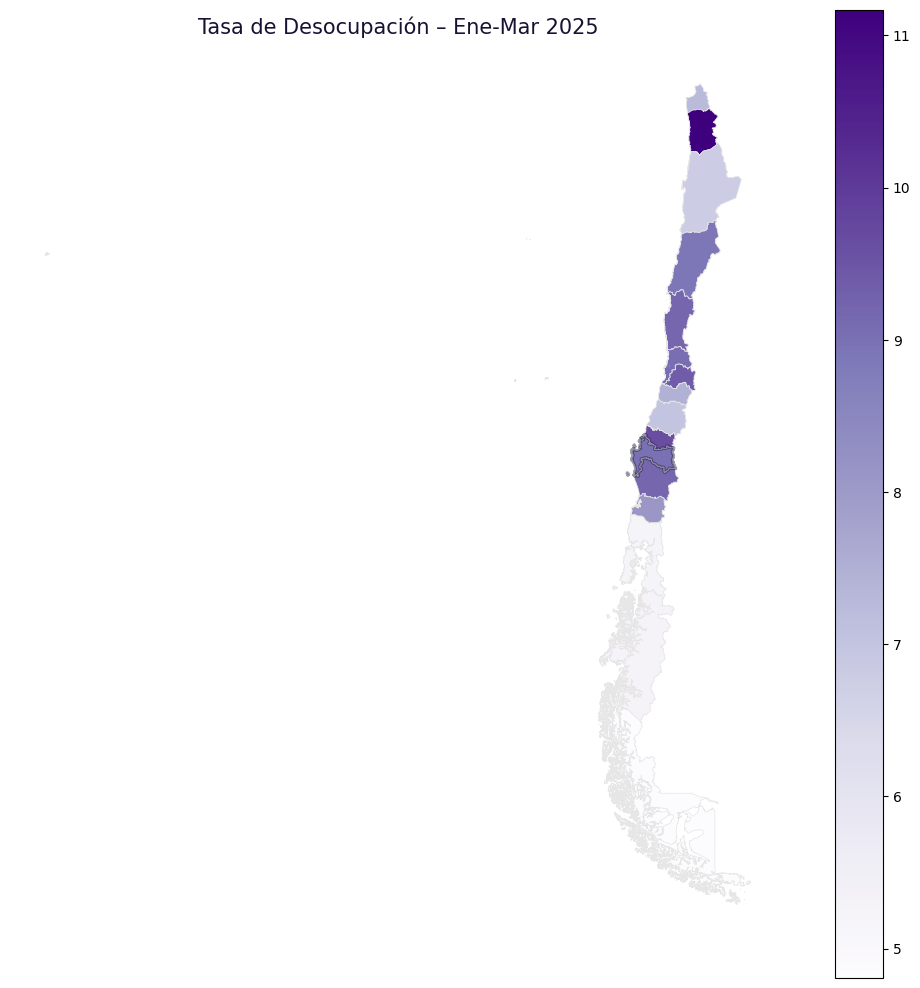

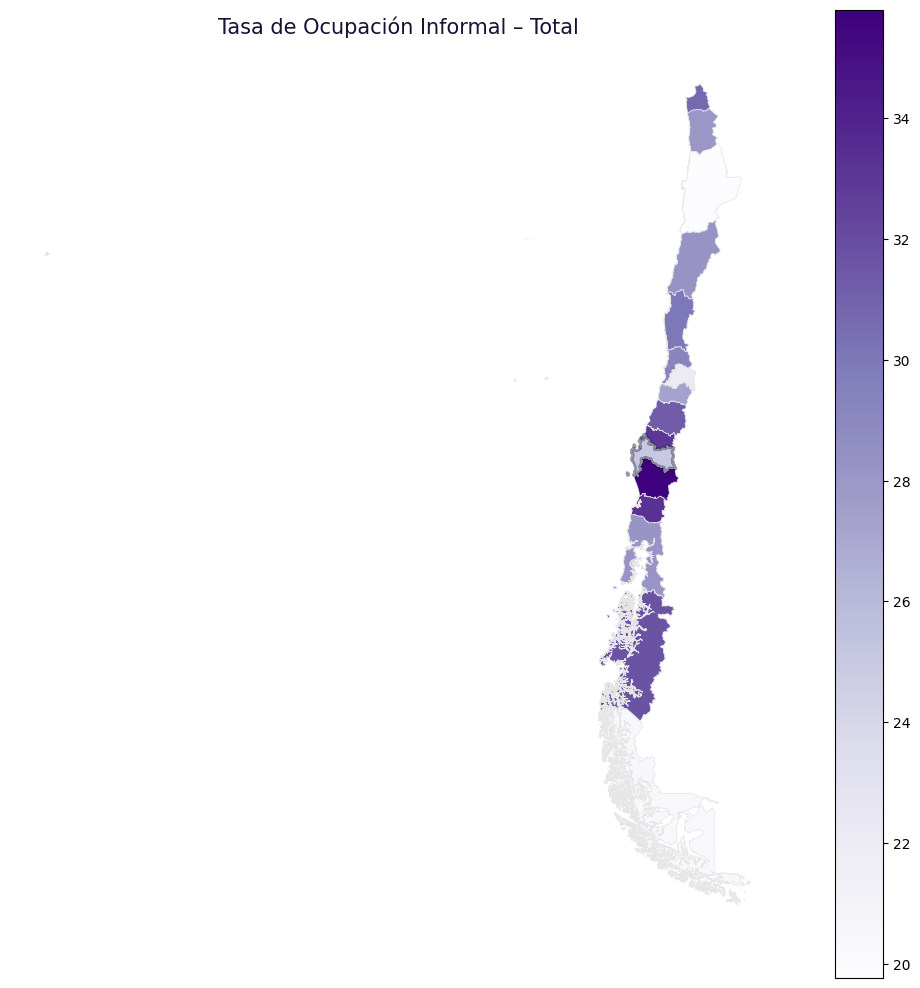

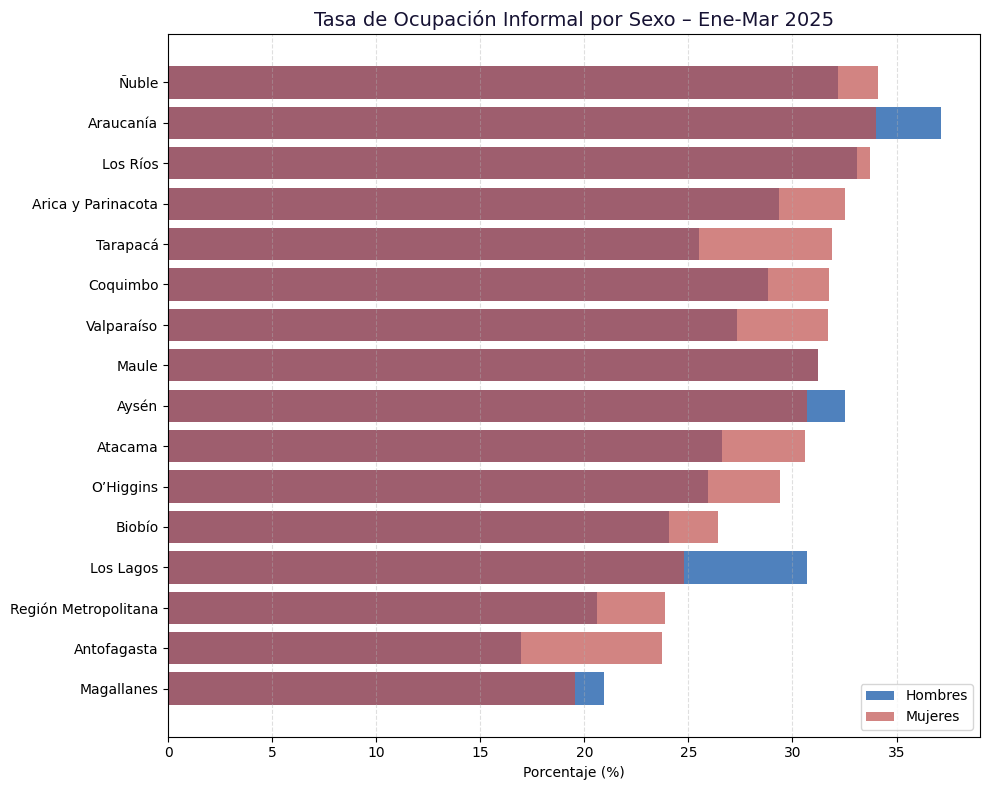

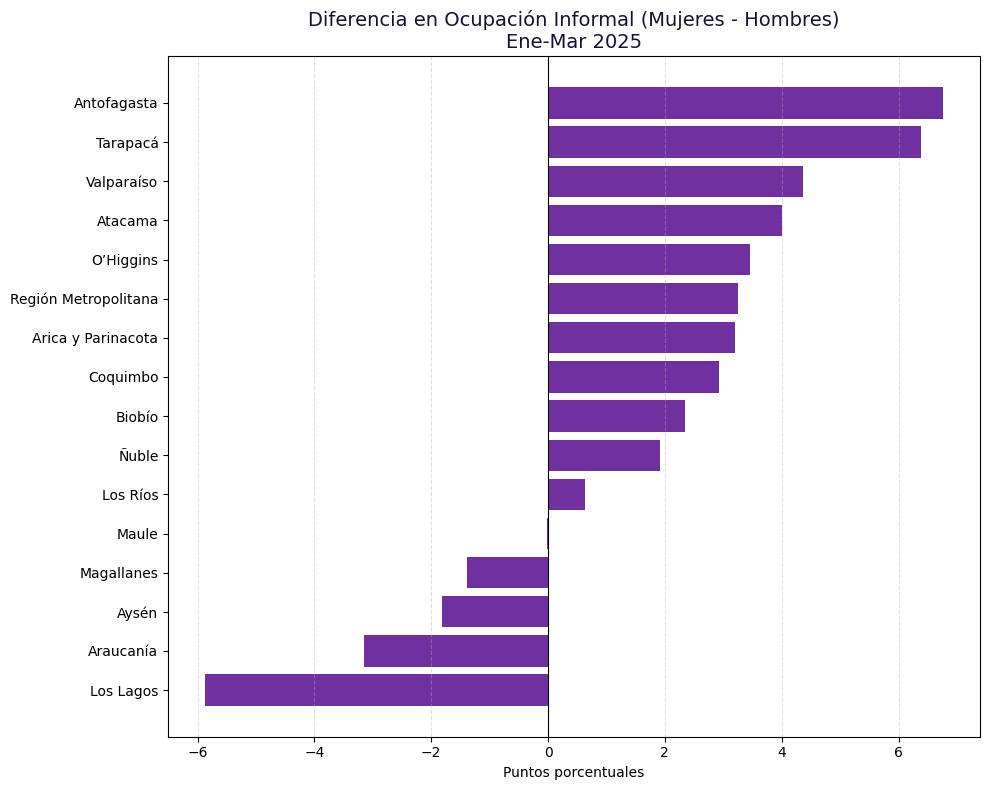

In [2]:
# 1. Librerías
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 2. Cargar datos
from google.colab import drive
drive.mount('/content/drive')

# 3. Paths
excel_path = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
shp_path = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/shp_regiones/Regional.shp"

# 4. Leer Excel
df = pd.read_excel(excel_path, sheet_name="TDO_2025")
df = df[df["region_name"] != "Nacional"]
TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
df["Periodo"] = pd.PeriodIndex(
    year=df["Año"],
    quarter=df["Trimestre"].map(TRIM_MAP),
    freq="Q"
)
df["Fecha"] = df["Periodo"].dt.start_time


# 5. Mapear nombres de región (para hacer merge con shapefile)
region_map = {
    'Antofagasta': 'Región de Antofagasta',
    'Araucanía': 'Región de La Araucanía',
    'Arica y Parinacota': 'Región de Arica y Parinacota',
    'Atacama': 'Región de Atacama',
    'Aysén': 'Región de Aysén del Gral.Ibañez del Campo',
    'Biobío': 'Región del Bío-Bío',
    'Coquimbo': 'Región de Coquimbo',
    'Los Lagos': 'Región de Los Lagos',
    'Los Ríos': 'Región de Los Ríos',
    'Magallanes': 'Región de Magallanes y Antártica Chilena',
    'Maule': 'Región del Maule',
    'O’Higgins': "Región del Libertador Bernardo O'Higgins",
    'Región Metropolitana': 'Región Metropolitana de Santiago',
    'Tarapacá': 'Región de Tarapacá',
    'Valparaíso': 'Región de Valparaíso',
    'Ñuble': 'Región de Ñuble'
}
df["Region_shp"] = df["region_name"].map(region_map)

# 6. Leer shapefile y hacer merge
gdf = gpd.read_file(shp_path)
gdf_merged = gdf.merge(df, left_on="Region", right_on="Region_shp")

# 7. Función para mapas
def plot_heatmap(gdf, column, title):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.plot(column=column, cmap="Purples", linewidth=0.5, edgecolor='0.9', ax=ax, legend=True)
    ax.set_facecolor("#ffffff")
    ax.set_title(title, fontsize=15, color="#161233")
    ax.axis("off")

    # Resaltar Biobío suavemente
    biobio = gdf[gdf["region_name"] == "Biobío"]
    biobio.plot(ax=ax, facecolor="none", edgecolor="#161233", linewidth=2, alpha=0.4)

    plt.tight_layout()
    plt.show()

# 8. Mapa: Tasa de Desocupación
plot_heatmap(
    gdf_merged,
    "T_TDO_indicadoresprincipales",
    "Tasa de Desocupación – Ene-Mar 2025"
)

# 9. Mapa: Tasa de Ocupación Informal (Total)
plot_heatmap(
    gdf_merged,
    "T_TOI_A_informalidadtasas",
    "Tasa de Ocupación Informal – Total"
)

# 10. Gráfico comparativo: Mujeres vs Hombres
df_bar = df.copy()
df_bar = df_bar.sort_values("T_TOI_M_informalidadtasas", ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(df_bar["region_name"], df_bar["T_TOI_H_informalidadtasas"], label="Hombres", color="#4F81BD")
plt.barh(df_bar["region_name"], df_bar["T_TOI_M_informalidadtasas"], label="Mujeres", color="#C0504D", alpha=0.7)
plt.title("Tasa de Ocupación Informal por Sexo – Ene-Mar 2025", fontsize=14, color="#161233")
plt.xlabel("Porcentaje (%)")
plt.legend(loc="lower right")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 11. Gráfico de diferencia (Mujeres - Hombres)
df_bar["diferencia_M_H"] = df_bar["T_TOI_M_informalidadtasas"] - df_bar["T_TOI_H_informalidadtasas"]
df_diff = df_bar.sort_values("diferencia_M_H", ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(df_diff["region_name"], df_diff["diferencia_M_H"], color="#7030A0")
plt.axvline(0, color='black', linewidth=0.8)
plt.title("Diferencia en Ocupación Informal (Mujeres - Hombres)\nEne-Mar 2025", fontsize=14, color="#161233")
plt.xlabel("Puntos porcentuales")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
